## Basics of TS

이 커널을 시계열 데이터를 활용하도록 만들어졌다.

### 파일 설명
- sales_train.csv- 훈련 세트. 2013 년 1 월부터 2015 년 10 월까지의 일일 기록 데이터입니다.
- test.csv- 테스트 세트. 이러한 상점과 제품의 2015 년 11 월 매출을 예측해야합니다.
- sample_submission.csv- 올바른 형식의 샘플 제출 파일.
- items.csv- 항목 / 제품에 대한 추가 정보.
- item_categories.csv-   항목 카테고리에 대한 추가 정보입니다.
- shops.csv- 상점에 대한 추가 정보.


### 데이터 필드
- ID-  테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id
- shop_id- 상점의 고유 식별자
- item_id- 상품의 고유 식별자
- item_category_id- 항목 카테고리의 고유 식별자
- item_cnt_day- 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.
- item_price- 상품의 현재 가격
- date  -dd / mm / yyyy 형식의 날짜
- date_block_num- 편의를 위해 사용되는 연속 월 번호입니다. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.
- item_name-  항목 이름
- shop_name- 상점 이름
- item_category_name- 항목 카테고리 이름

## Table of contents

- Competition and data overview
- Imports ( data and packages )
- Basic exploration/EDA
- Single time-series
    - Stationarity
    - Seasonality , Trend and Remainder
    - AR , MA , ARMA , ARIMA
    - Selecting P and Q using AIC
    - ETS
    - Prophet
    - UCM
- Hierarchical time-series
    - Bottom's up
    - AHP
    - PHA
    - FP

## Competition and data overview:

- IC 회사는 어떤 일을 하는가?  
    Enterprise 8 system of programs은 관리 회계, 비즈니스 회계, HR 관리, CRM, SRM, MRP, MRP 등과 같은 경제 및 관리 활동의 다양한 비즈니스 작업과 같은 일상적인 기업 활동을 자동화 하는 일을 한다.  
    
    
- 데이터  
    각 지점-물건의 조합에 대한 일일 판매 데이터가 제공되지만, 우리는 **매월** 판매랑을 예측해야된다.

## Imports ( data and packages )

In [37]:
!ls ../data/*

../data/item_categories.csv  ../data/sales_train.csv	    ../data/shops.csv
../data/items.csv	     ../data/sample_submission.csv  ../data/test.csv


In [38]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import os
from os.path import join
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

### 6개의 .csv 파일을 불러옵니다

In [39]:
# Import all of them 
data_dir = os.getenv('HOME')+'/repo/AIFFEL_Merona/data'

sales_train_path = join(data_dir, 'sales_train.csv')
item_cat_path = join(data_dir, 'item_categories.csv') 
items_path = join(data_dir, 'items.csv')
sample_submission_path = join(data_dir, 'sample_submission.csv') 
shops_path = join(data_dir, 'shops.csv')
test_path = join(data_dir, 'test.csv') 



# settings
import warnings
warnings.filterwarnings("ignore")

sales=pd.read_csv(sales_train_path)
item_cat=pd.read_csv(item_cat_path)
item=pd.read_csv(items_path)
sub=pd.read_csv(sample_submission_path)
shops=pd.read_csv(shops_path)
test=pd.read_csv(test_path)

### sales_train.csv에 있는 열들의 이름과 타입을 확인합니다

In [40]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


### 월별로 sales를 정리해봅니다.

In [41]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## 코드 라인을 하나씩 분해해 보겠습니다.:
# 날짜 블록(월), shop_id 및 item_id별로 집계한다.
# 열에서 date, item_price 및 item_cnt_day(매출) 선택한다.
# 각 열에 대해서 수행할 집계(?)를 미리 제공합니다.
# min and max on the date
# average of the item_price
# sum of the sales

In [42]:
# take a peak
monthly_sales.head(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

위에서 설정한 대로 정렬되어 있는 모습을 볼 수 있습니다.

### 카테고리별 개수을 확인합니다.

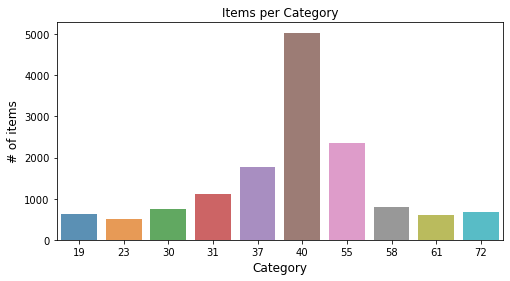

In [43]:
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

이번 데이터셋에는 살펴볼 게 많다고 합니다. 하지만 여기서는 시계열적인 특성 측면에서 보기로 합니다.

## Single series

우리의 목표는 store-item 조합에서 다음 달의 판매를 예측하는 것입니다.  
각 store-item의 시간 경과에 따른 판매량은 그 자체로 시계열 데이터 입니다. 모든 조합에 대해 알아보기 전에 먼저 각각의 single series에 대해 예측하는 법을 이해하겠습니다.  
저는 회사 전체의 월별 총 매출을 예측하기로 결정했습니다.  
먼저 월별 총 매출을 계산하고 해당 데이터를 plot 해보겠습니다. 

### 월별 판매 개수에 대한 그래프

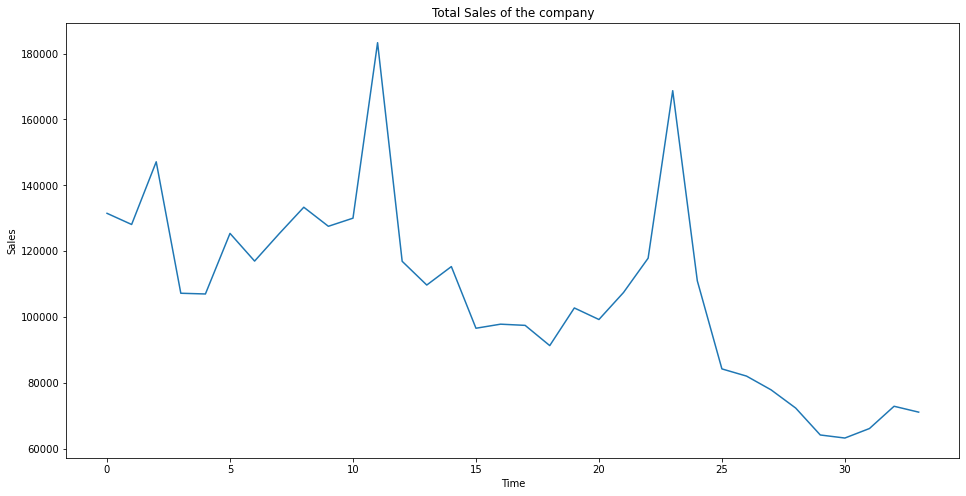

In [44]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

코드를 보면 date_block_num과 item_cnt_day의 상관관계를 그래프로 표현한 것을 알 수 있습니다.  
- date_block_num- 편의를 위해 사용되는 연속 월 번호입니다. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.
- item_cnt_day- 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.  


즉 이 그래프는 월별 판매 개수를 그래프로 표현한 것입니다.  

### 구간 통계치(Rolling Statistics) 시각화

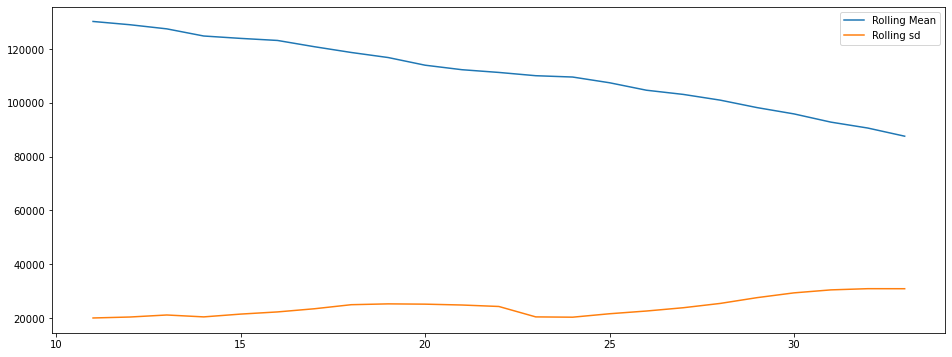

In [45]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

월별 판매량 그래프의 원본 그래프를 보면 들쭉날쭉해서 좀처럼 경향을 파악하기 어렵습니다.  
그래서 평균과 분산을 활용해서 대충이라도 경향성을 확인해 보겠습니다.  

### Statsmodels 패키지를 활용한 decompose

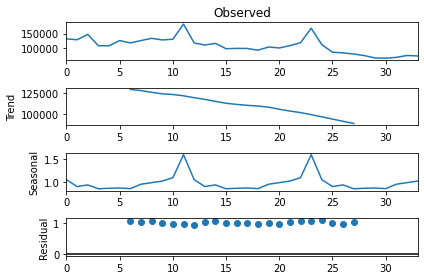

In [46]:
#시계열 분해 (Time Series Decomposition)
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

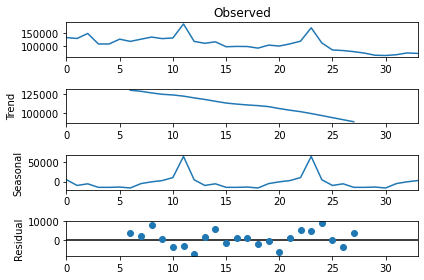

In [47]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

yt = St + Tt + Et  

- yt: 기간 t의 데이터
- St: 기간 t의 seasonal 성분
- Tt: 기간 tt의 trend-cycle 성분
- Et는 기간 t의 remainde (또는 불규칙 또는 오류) 성분

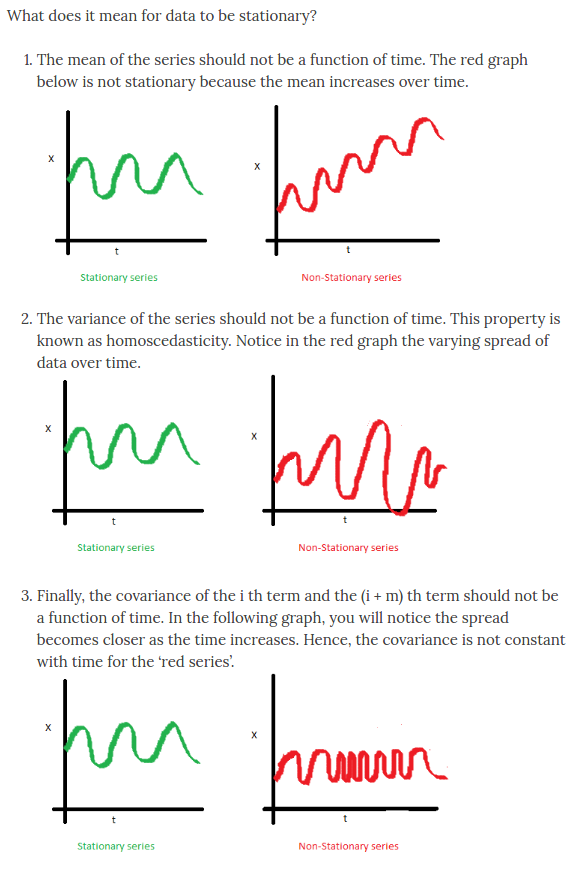

### 안정성 테스트

시계열 데이터를 안정성을 확인하는 데 사용할 수 있는 테스트는 여러가지가 있습니다.  
- ADF (증강 Dicky Fuller 테스트)
- KPSS
- PP (Phillips-Perron 테스트)  

여기서는 가장 일반적으로 사용되는 ADF를 수행하겠습니다.

In [48]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


p-value가 0.142953이 나왔습니다.   
안정적 시계열이라는 대립가설을 채택하기엔 무리가 있어보입니다.

### 안정성을 위한 difference

In [50]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

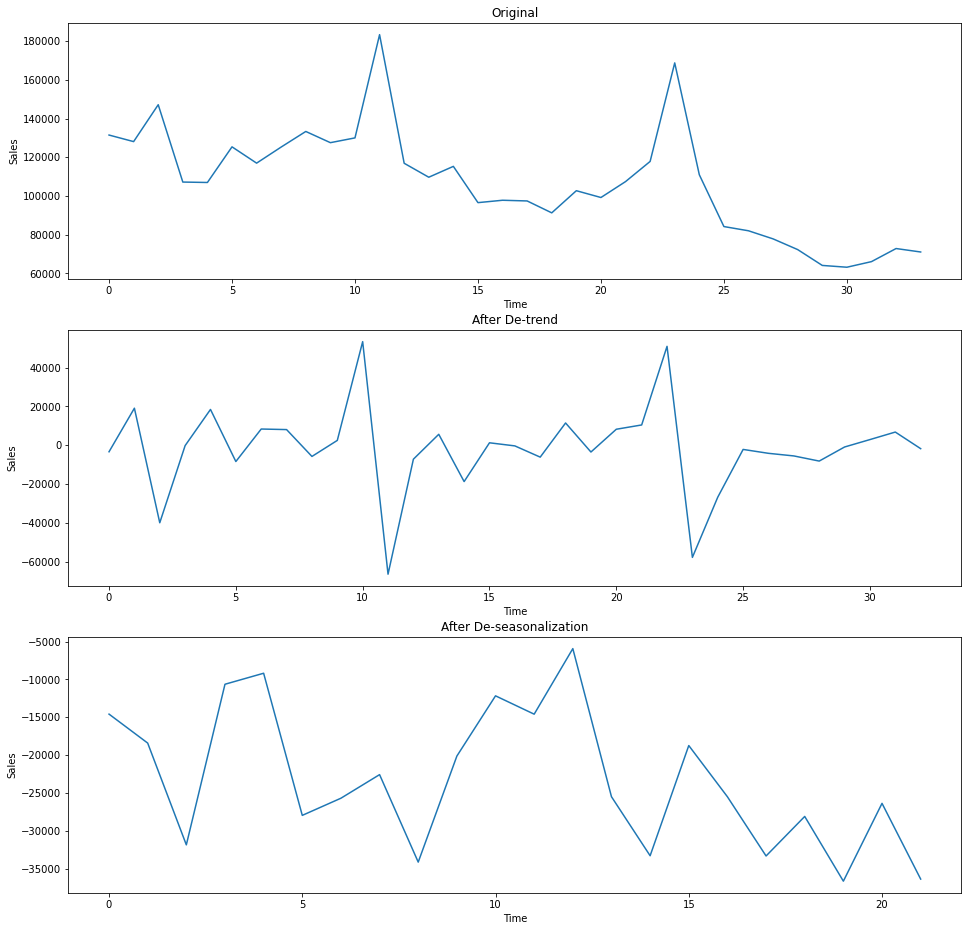

In [51]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
# trend 성분 제거
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

# seasonality 성분 제거
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [52]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


p-value가 0에 가까운 모습을 볼 수 있습니다.  
따라서 우리는 이 시계열 데이터가 안정성을 가졌다고 가정할 수 있습니다. 

## 예측하기

### AR, MA and ARMA models

In [61]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

### AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

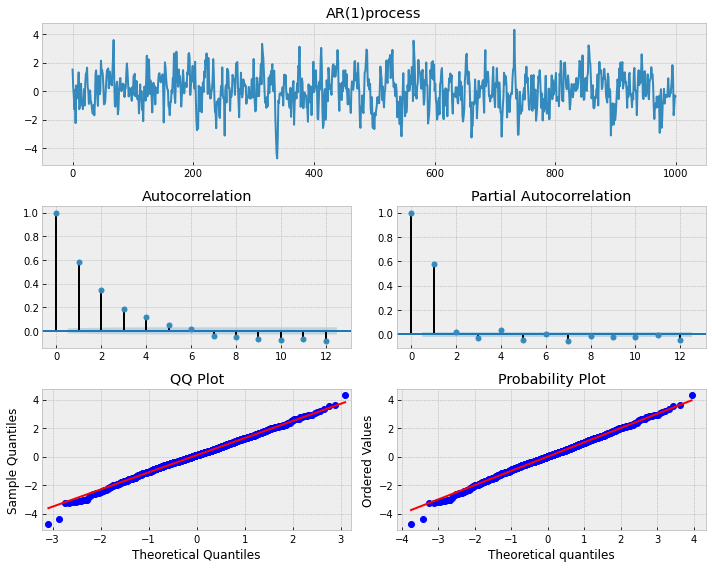

In [62]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

### AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

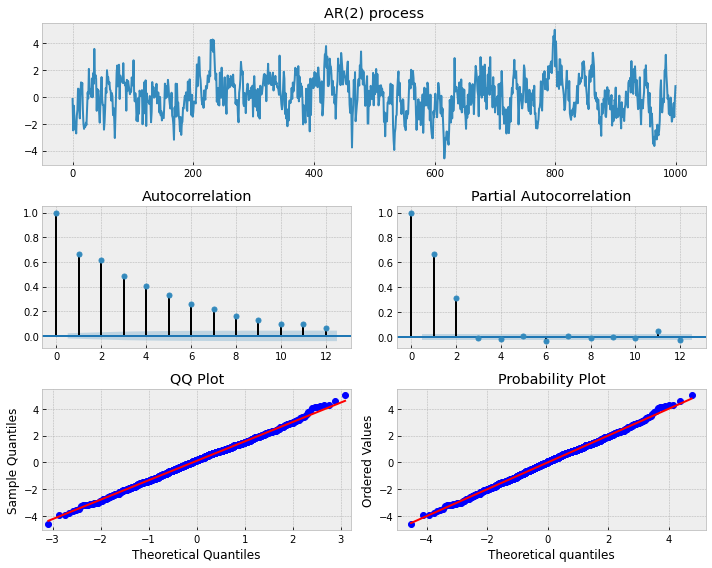

In [55]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

### MA(1) process -- has ACF cut off at lag=1

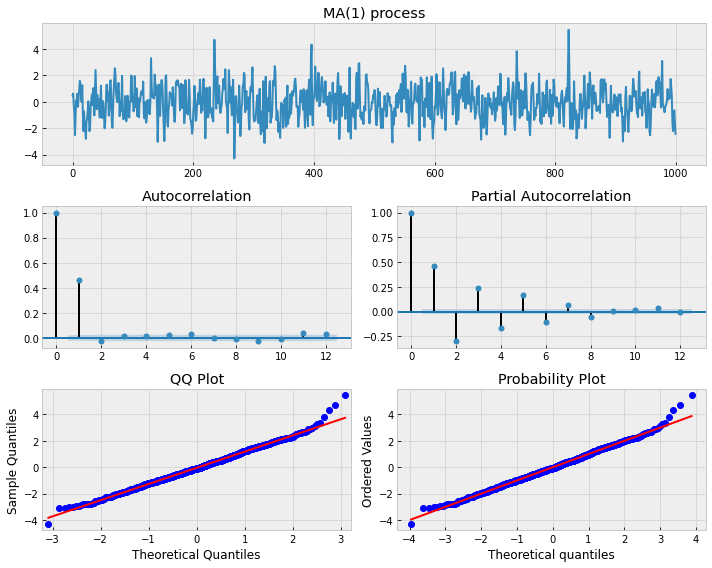

In [56]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

### MA(2) process -- has ACF cut off at lag=2

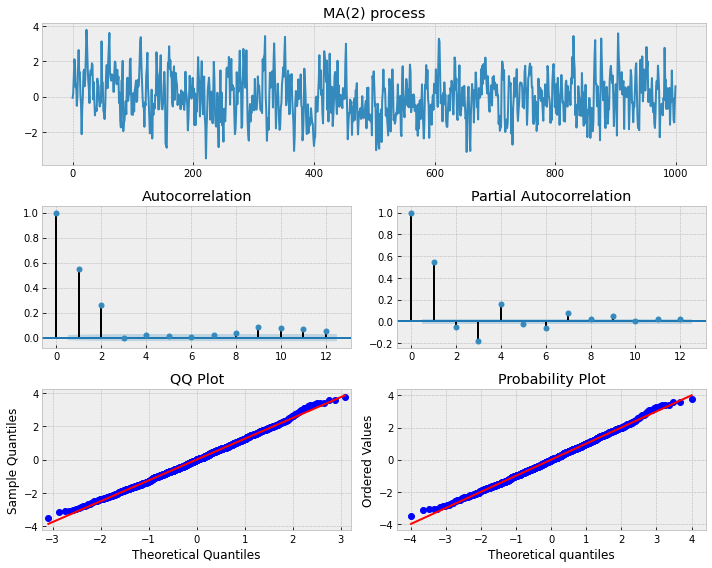

In [57]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## ARMA(2,2) process

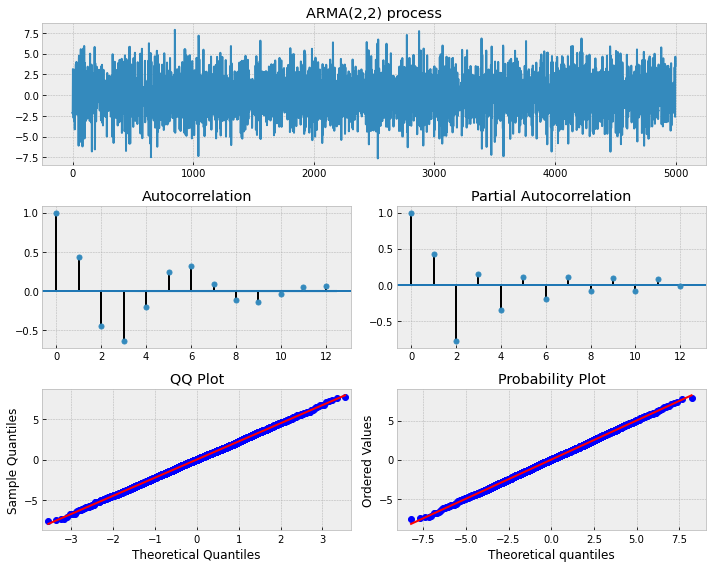

In [58]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")